In [336]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, QTable, join
import glob
import thejoker as tj
import pymc as pm
import corner
from astropy import constants as const

import arviz as az
import astropy.units as u
from astropy.time import Time
from utils import PLOT_PARAMS
PLOT_PARAMS()

In [2]:
apogee_gold  = Table.read("../../lithium/cosmic/apogee_goldsample.fits")
apw_binaries = Table.read('../../lithium/cosmic/apw_binaries.fits')


In [3]:
apogee_dr16_visit = Table.read('../files/apogee_dr16_allVisit-r12-l33.fits')
apogee_dr16_visit.convert_bytestring_to_unicode()


In [4]:
apogee_dr16 = Table.read('../../lithium/data/allStarLite-r12-l33.fits')
apogee_dr16.convert_bytestring_to_unicode()
apogee_dr16 = apogee_dr16[(apogee_dr16['TEFF']>0) & (apogee_dr16['LOGG']>-9000.) ]


In [5]:
galah_mag_lower, galah_mag_upper = 7.456999778747559, 11.829999923706055
mag_lower, mag_upper = 7,12
apogee_rg = apogee_dr16[(apogee_dr16['TEFF']<=5730) & (apogee_dr16['TEFF']>=3000) & 
                        (apogee_dr16['LOGG']<=3.2) & (apogee_dr16['LOGG']>=-1) & 
                        (apogee_dr16['NVISITS']>=4) &
                        (apogee_dr16['WASH_DDO51_GIANT_FLAG']==1) & 
                        (apogee_dr16['J']>=mag_lower) & (apogee_dr16['J']<=mag_upper) 
                        
                       ]
len(apogee_rg)

4363

In [6]:
len(apogee_dr16_visit)

1778792

In [7]:
mask = np.isin(apogee_dr16_visit['APOGEE_ID'], apogee_rg['APOGEE_ID'])

apogee_dr16_visit = apogee_dr16_visit[mask]

In [8]:
apogee_cut  = apogee_rg.copy()
apogee_cut2 = apogee_dr16_visit.copy()

# merged = join(apogee_cut, apogee_cut2, keys='APOGEE_ID')


In [9]:

keep_star = []
for i in apogee_cut:
    starflag   = str(i['STARFLAG'])
    aspcapflag = str(i['ASPCAPFLAG'])
    
    if '3' not in starflag and '16' not in starflag and '16' not in aspcapflag \
    and '17' not in aspcapflag and '18' not in aspcapflag and '26' not in aspcapflag and '30' not in aspcapflag:
        keep_star.append(i['APOGEE_ID'])
        
mask = np.isin(apogee_cut['APOGEE_ID'], keep_star)

apogee_rg_good = apogee_cut[mask]


In [10]:
keep_visit = []
for i in apogee_cut2:
    starflag = str(i['STARFLAG'])
    visit_id = i['VISIT_ID']
    if '3' not in starflag and '9' not in starflag and '12' not in starflag and '13' not in starflag and '16' not in starflag:
        keep_visit.append(visit_id)

mask = np.isin(apogee_cut2['VISIT_ID'], keep_visit)
apogee_visit_good = apogee_cut2[mask]


In [11]:
merged = join(apogee_rg_good, apogee_visit_good, keys='APOGEE_ID', join_type='left')

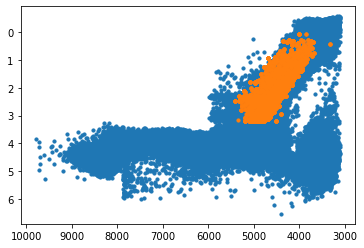

In [12]:
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'],s=10)
plt.scatter(merged['TEFF'],merged['LOGG'],s=10)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [13]:
def run_joker(data,Pi,Pf,K0=20, max_posterior=1000, error=0.1,prior_size=1_000_000):#,save=False,MCMC=False):
    time, rv, err = data[0], data[1], data[2]
    err            = np.array(err)
    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    err[(err<0.10)] = 0.10
    
    data           = Table()
    data['bmjd']   = time
    data['rv']     = rv
    data['rv_err'] = err

    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    t = Time(data["bmjd"], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v=100*u.km/u.s,            
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    
    joker = tj.TheJoker(prior, rng=rnd)


    #print('running joker for posterior samples...')
    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=max_posterior,
                                           return_all_logprobs=True)

#     joker_samples = joker.iterative_rejection_sample(data, prior_samples,n_requested_samples=1000)
# #                                                      return_all_logprobs=True)
    print('# of joker samples returned second round:',len(joker_samples[0]))
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    _ = tj.plot_rv_curves(
            joker_samples[0],
            data=data,
            ax=ax,
        )
    
    return joker_samples
    

In [14]:
# merged[merged['APOGEE_ID']=='2M22141062-0225513'][['JD','VHELIO','VRELERR']]

# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']=='2M22141062-0225513'][['JD','VHELIO','VRELERR','STARFLAGS']]

In [26]:

unique_apogee_id = list(set(merged['APOGEE_ID']))
print('# of unique RGs:',len(unique_apogee_id))

done = glob.glob('apogee_reference_samples/*.hdf5')
done = [i.split('/')[-1] for i in done]
done = [i.split('.hdf5')[0] for i in done]
done = list(set(done))

print('done',len(done))
print(len(set(unique_apogee_id)))
print(len(list(set(unique_apogee_id) - set(done))))


# of unique RGs: 3632
done 3504
3632
473


In [27]:
def check_masked_stars():
    
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    masked = []
    not_masked = []
    for i,star in enumerate(unique_apogee_id):
#         print(i, star)

        dtemp   = merged[merged['APOGEE_ID'] == star]
        if len(dtemp) == 1 and dtemp.has_masked_values is True:
            masked.append(star)
        else:
            not_masked.append(star)
    return masked, not_masked

masked, not_masked = check_masked_stars()


# of unique RGs: 3632


In [28]:
len(masked),len(not_masked)


(473, 3159)

In [29]:
plt.rcParams['figure.facecolor'] = 'white'

In [30]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    unique_apogee_id = list(set(unique_apogee_id) - set(done))
    print('# of unique RGs:',len(unique_apogee_id))
    
    for i,star in enumerate(unique_apogee_id):
        #if i<1847: continue
        #680 is when i started to reduce the posterior/prior size
        print(i, star)
        
        dtemp   = merged[merged['APOGEE_ID'] == star]
        if len(dtemp) == 1 and dtemp.has_masked_values is True:
            print('\t','masked content.')
            continue
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time    = dtemp['JD'].value
        
        mask = (err<10.)
        
        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time = Time(time, format="jd", scale="tcb")
        time = time.mjd
        #print('\t 2')
        data = [time, rv_vals, err]
        data = np.array(data)
        np.save('apogee_reference_samples/%s.npy'%star, data )
        #print('\t 3')
        joker_samples = run_joker(data, Pi=1, Pf=3000, prior_size=100_000, max_posterior=256 )
        #print('\t 4')
        save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
        joker_samples[0].write(save_dir, overwrite=True)
        print('\n')
        
pipeline()


# of unique RGs: 3632
# of unique RGs: 473
0 2M07360198+2127554
	 masked content.
1 2M07461396+6549226
	 masked content.
2 2M12490959-0811313
	 masked content.
3 2M07393563+6533204
	 masked content.
4 2M15043411+2635261
	 masked content.
5 2M13235899-0141531
	 masked content.
6 2M13221698-0212358
	 masked content.
7 2M17074184+5846253
	 masked content.
8 2M15012651+2107322
	 masked content.
9 2M07393703+2125272
	 masked content.
10 2M22101210-0237388
	 masked content.
11 2M16012955-1122281
	 masked content.
12 2M16291010-0056079
	 masked content.
13 2M12182797+1348552
	 masked content.
14 2M16301736-0117031
	 masked content.
15 2M14442466+1226131
	 masked content.
16 2M17500320+7355078
	 masked content.
17 2M16044231-1126458
	 masked content.
18 2M17490328+7356062
	 masked content.
19 2M10414907+1928517
	 masked content.
20 2M17115494+4742064
	 masked content.
21 2M16385594-0044328
	 masked content.
22 2M17172092+4759259
	 masked content.
23 2M15024459+2152434
	 masked content.
24 2M17

	 masked content.
216 2M11450535+3408217
	 masked content.
217 2M16543156+1027437
	 masked content.
218 2M16303913-1320167
	 masked content.
219 2M14551593+4051588
	 masked content.
220 2M07330510+2121254
	 masked content.
221 2M14570345+4125531
	 masked content.
222 2M14594176+4053412
	 masked content.
223 2M01425068+8439440
	 masked content.
224 2M16585653+1037148
	 masked content.
225 2M14450532+1216338
	 masked content.
226 2M07333444+6543312
	 masked content.
227 2M12332011+5637015
	 masked content.
228 2M10393012+1938046
	 masked content.
229 2M22160103-0233122
	 masked content.
230 2M21250034+1147558
	 masked content.
231 2M16291268-0103127
	 masked content.
232 2M16542215+1042368
	 masked content.
233 2M11444353+3414291
	 masked content.
234 2M11065135-0622569
	 masked content.
235 2M07431890+6544342
	 masked content.
236 2M07392403+2109415
	 masked content.
237 2M14595516+4115176
	 masked content.
238 2M16252855-1315299
	 masked content.
239 2M17035364+5912375
	 masked content

	 masked content.
426 2M07325609+2107546
	 masked content.
427 2M07501378+6534322
	 masked content.
428 2M12223527+5626198
	 masked content.
429 2M07425422+2055287
	 masked content.
430 2M16003726-1109132
	 masked content.
431 2M16331478-1310485
	 masked content.
432 2M16524711+1042581
	 masked content.
433 2M17241637+4755163
	 masked content.
434 2M16262433-1308454
	 masked content.
435 2M16272626-1309021
	 masked content.
436 2M07480843+6543282
	 masked content.
437 2M22134816-0244445
	 masked content.
438 2M07431248+2045420
	 masked content.
439 2M01253321+1647343
	 masked content.
440 2M15073454+2142198
	 masked content.
441 2M16343943-0106453
	 masked content.
442 2M17091603+4805421
	 masked content.
443 2M17150336+4814398
	 masked content.
444 2M14573917+3649269
	 masked content.
445 2M12441419-0751315
	 masked content.
446 2M07431136+2054133
	 masked content.
447 2M13221514-0222269
	 masked content.
448 2M13303209-0142351
	 masked content.
449 2M16242894-1306599
	 masked content

# of unique RGs: 3632
done: 3504
remaining: 473


<ipython-input-21-cbcbef4a30d8>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))


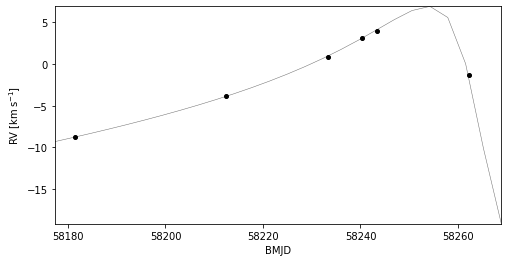

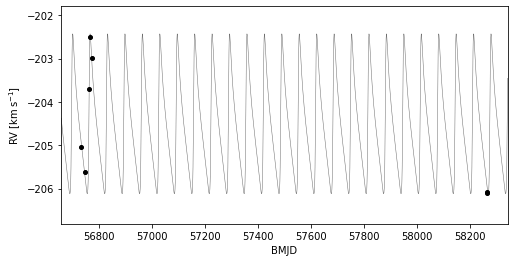

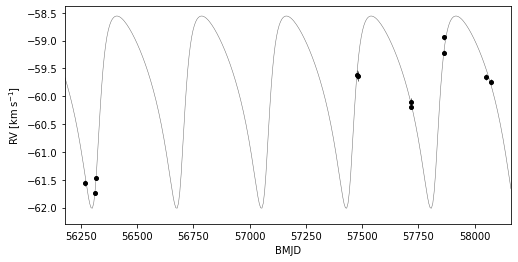

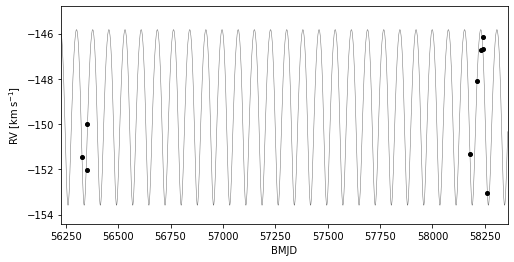

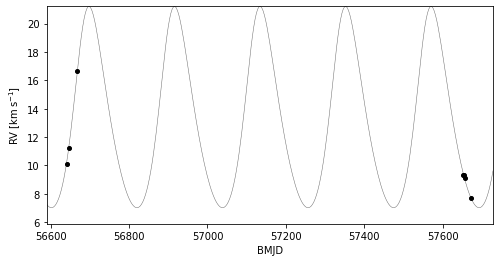

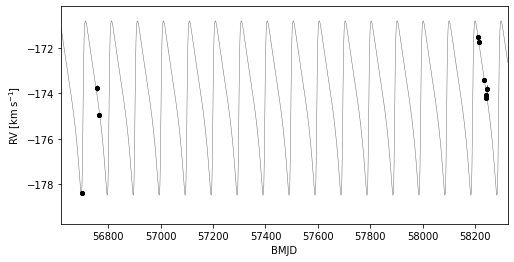

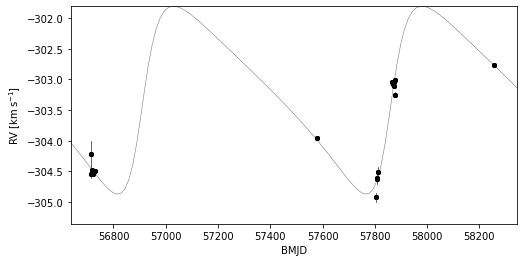

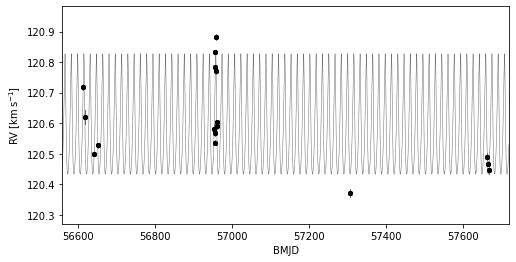

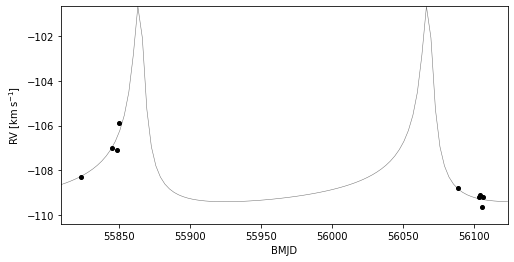

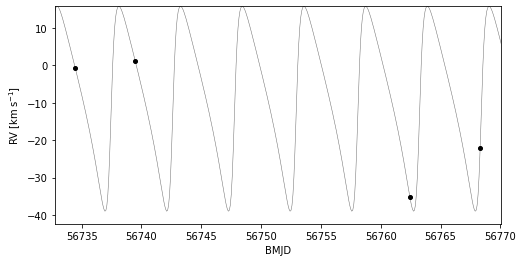

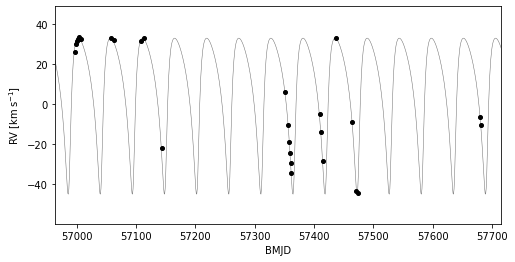

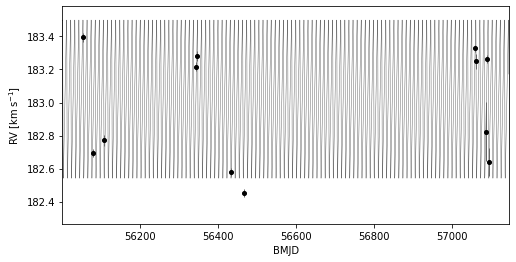

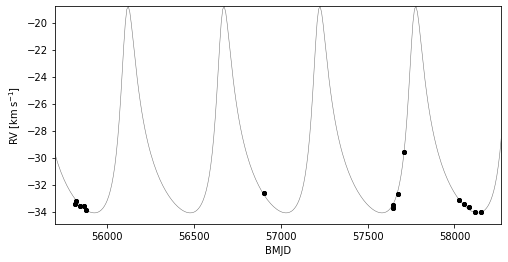

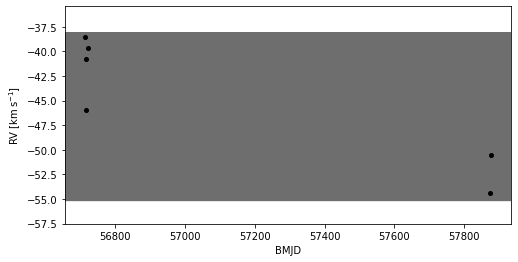

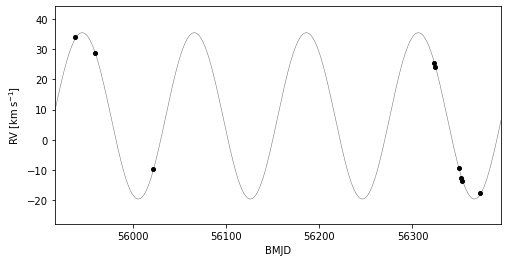

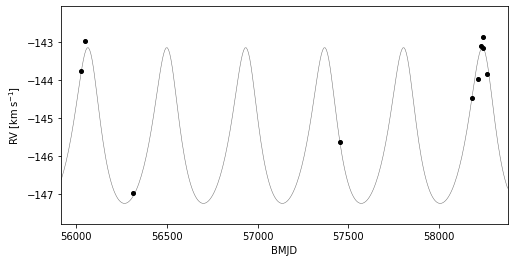

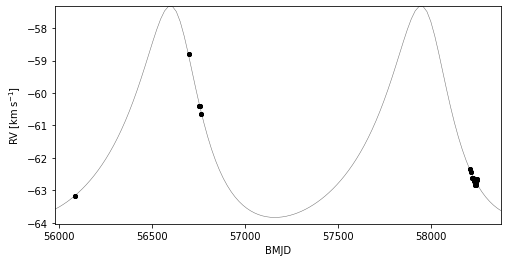

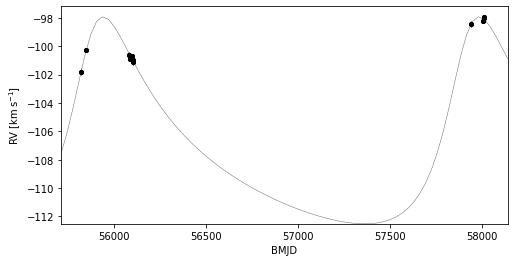

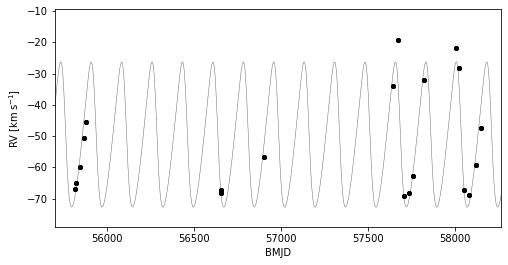

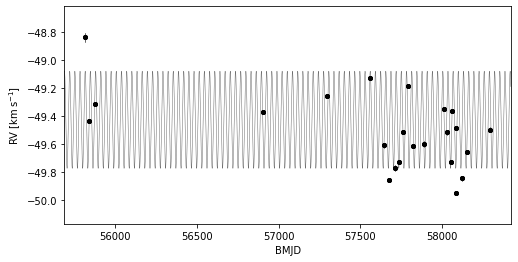

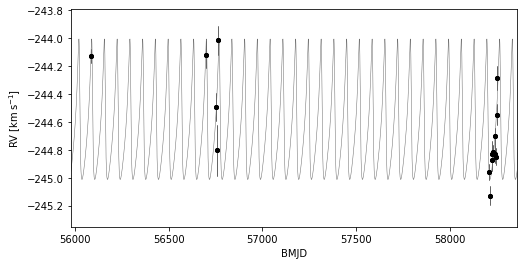

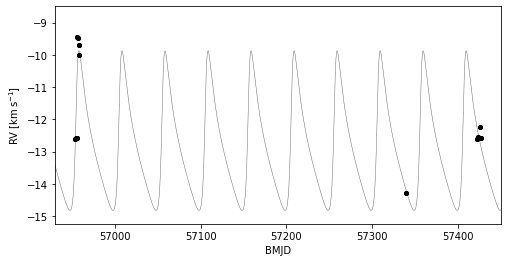

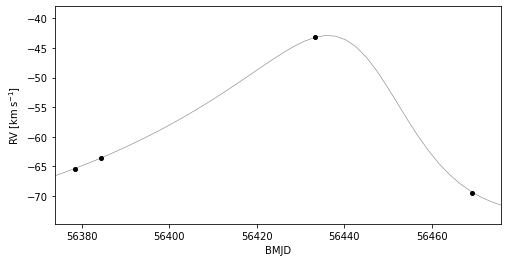

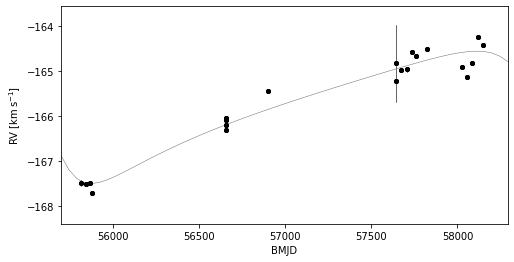

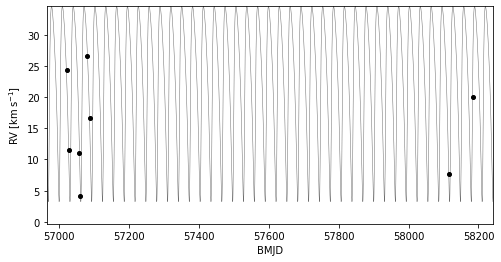

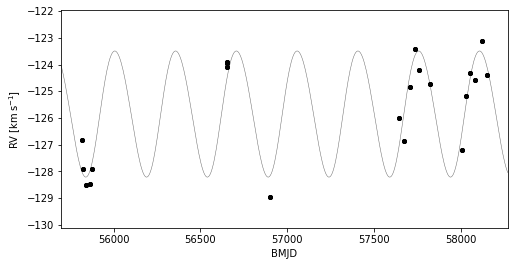

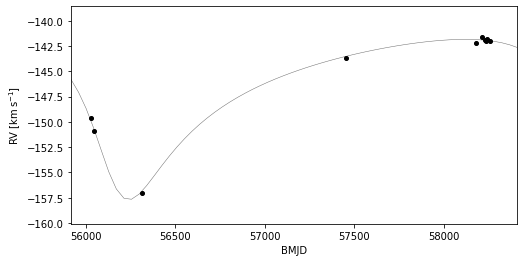

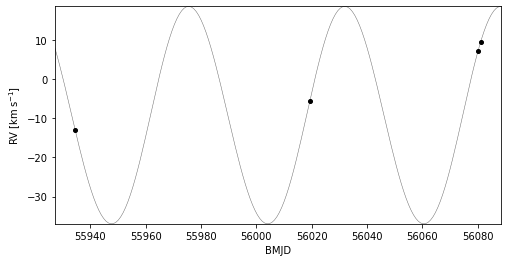

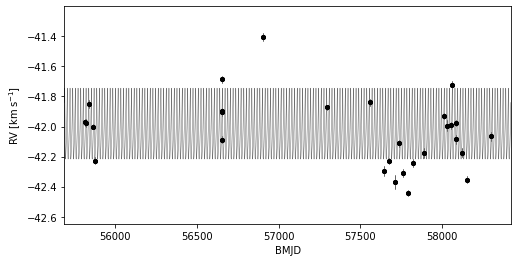

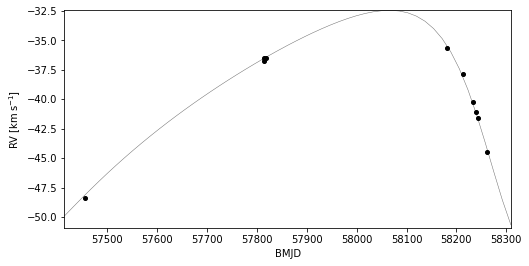

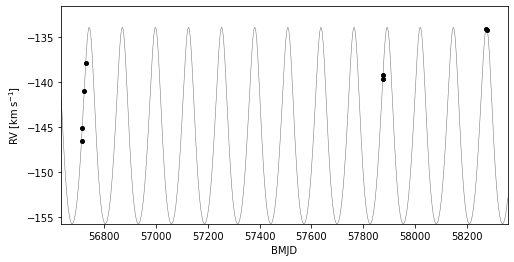

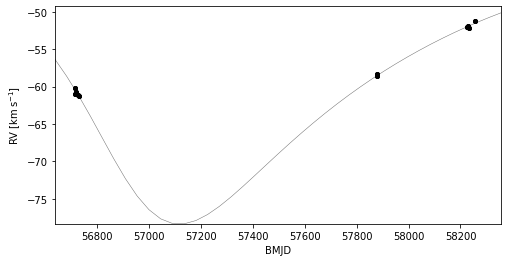

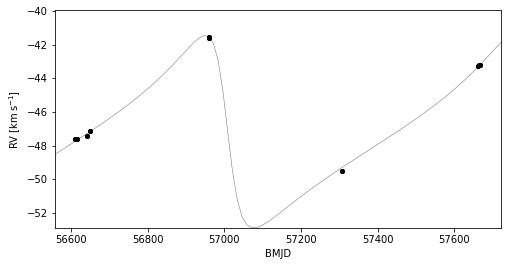

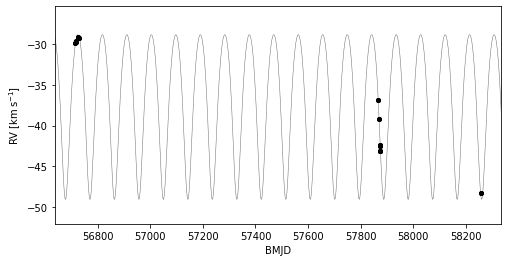

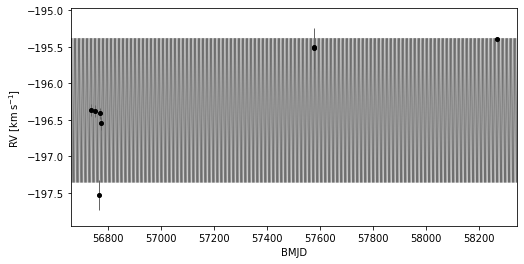

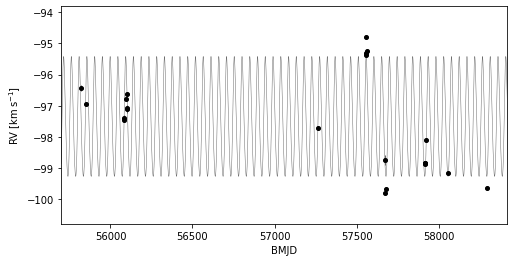

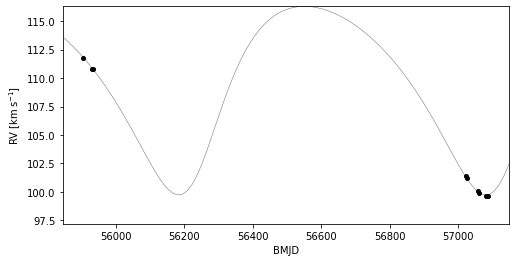

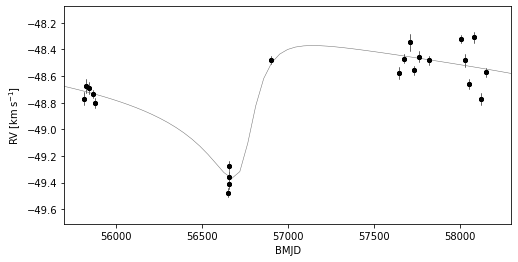

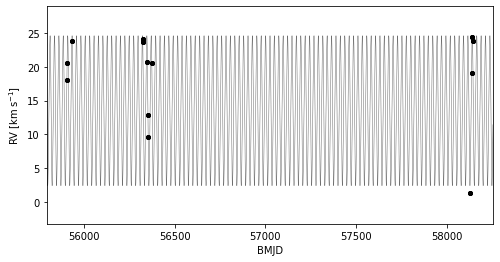

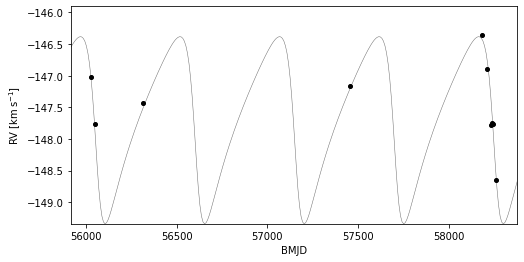

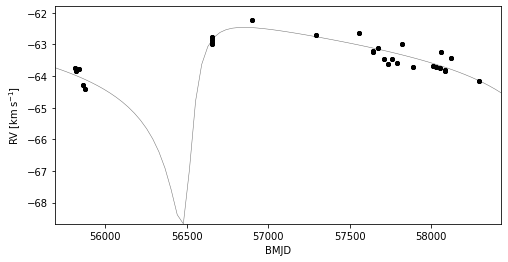

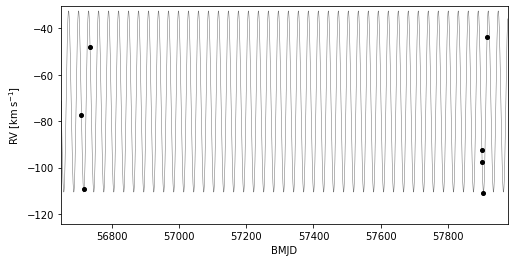

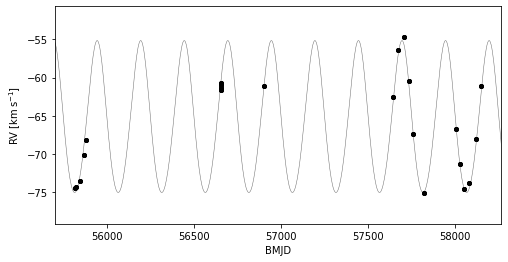

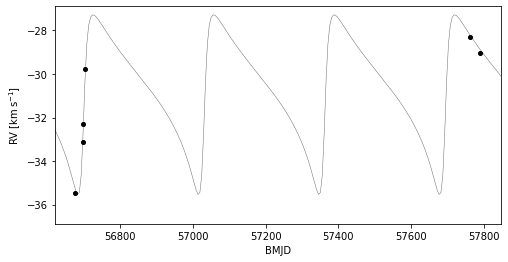

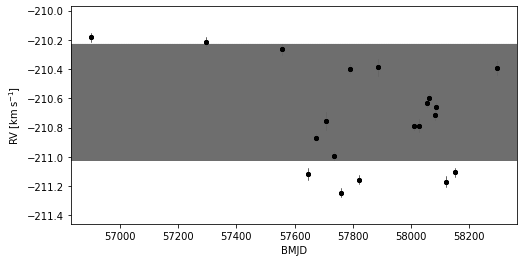

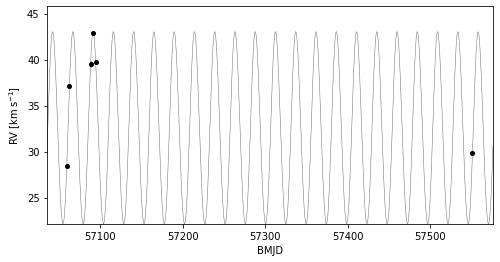

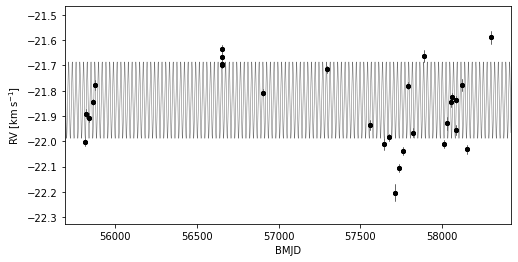

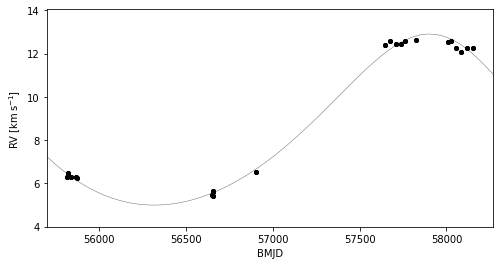

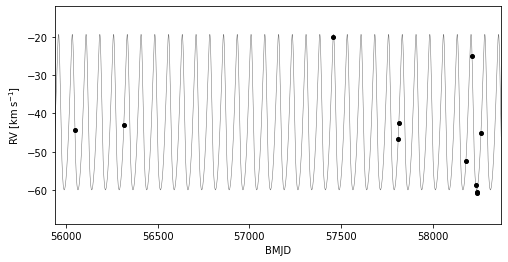

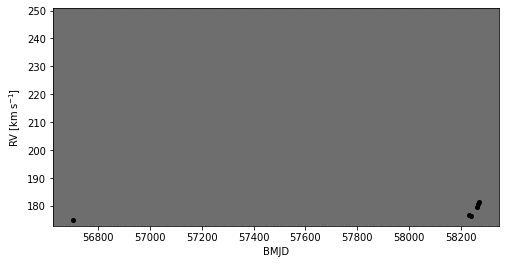

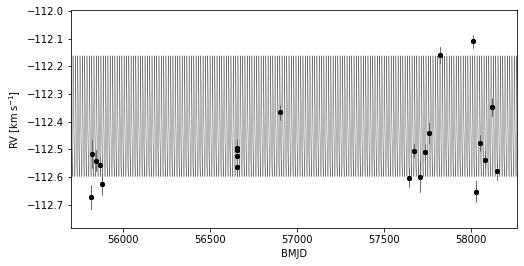

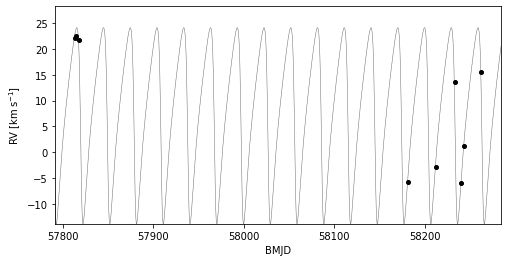

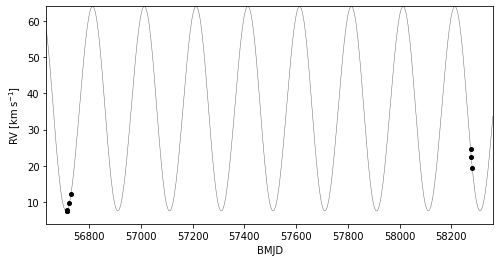

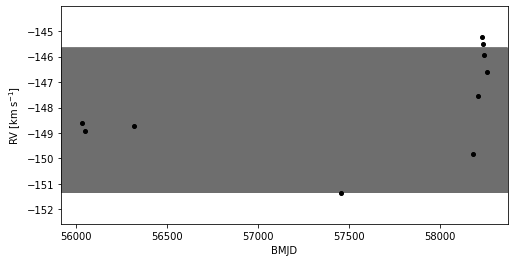

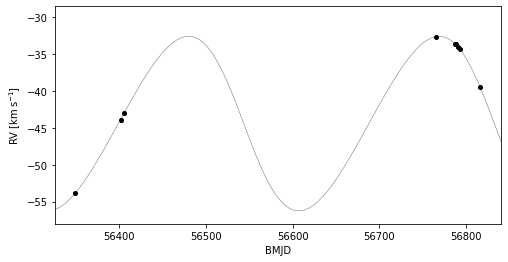

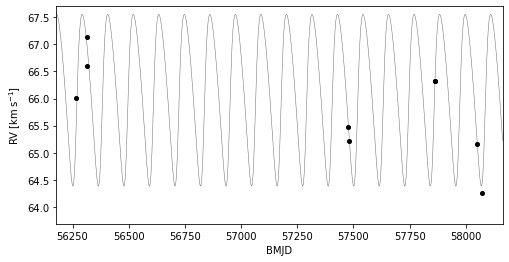

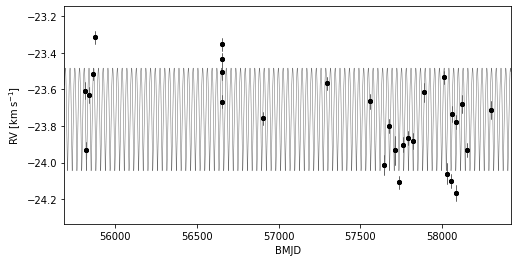

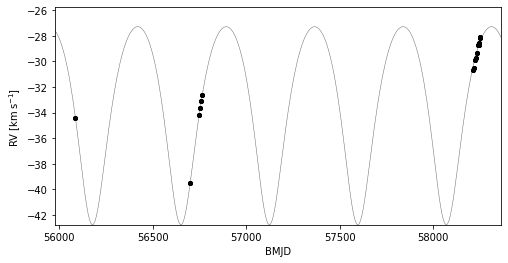

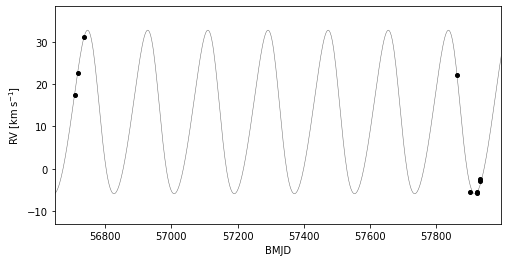

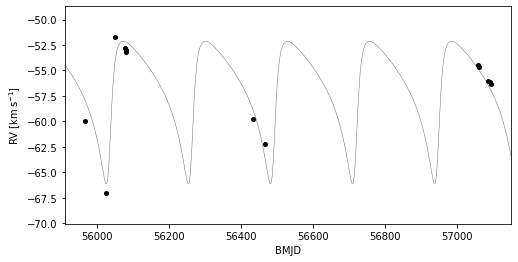

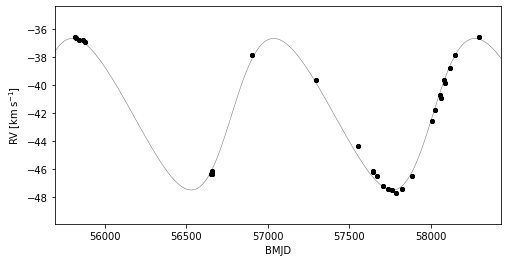

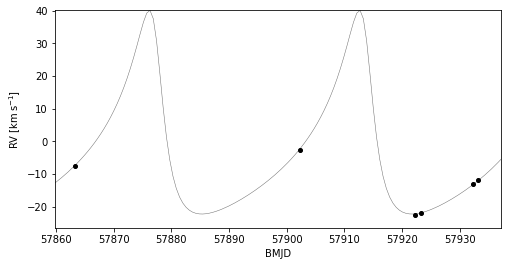

In [31]:
def check_amp():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))

    files = glob.glob('apogee_reference_samples/*.hdf5')
    names = [file.split('/')[-1].split('.')[0] for file in files]
    
    print('done:',len(set(names)))
    print('remaining:',len(list(set(unique_apogee_id)-set(names))))

    c_uni_modal = []
    c_multi     = []
    n_samples   = []
    
    for file in files:
        name = file.split('/')[-1].split('.')[0]
        if name in unique_apogee_id:
            samples = tj.JokerSamples.read(file)
            if len(samples) == 1:
                #reload(name, n=1)
                c_uni_modal.append(name)
            else:
                c_multi.append(name)
    return [c_uni_modal, c_multi]

n_samples = check_amp()

In [34]:
def func2(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def check_K(name):
    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    K_vals  = abs(samples['K'].value)
    perc_5  = np.percentile(K_vals, 5) #km/s
    logg    = merged[merged['APOGEE_ID']==name]['LOGG'].value[0]
    exp_35  = func2(logg)/1000.
    obs_K   = perc_5*1
    #print('exp: %.2f \t obs: %.2f'%(exp_35, obs_K))
    return obs_K,exp_35

yes_names = []
for i,name in enumerate(n_samples[1]):
    obs_K, exp_35 = check_K(name)
    if obs_K >= exp_35:
        yes_names.append(name)


In [40]:
Queiroz_2019 = Table.read('../files/Queiroz_2019.fit')

In [50]:
len(set(np.array(Queiroz_2019['ID']).astype('str')) & set(np.array(merged['APOGEE_ID']).astype('str') ))

3601

In [53]:
len(set(merged['APOGEE_ID']))

3632

In [54]:
uni_modal_samples = n_samples[0]
mul_modal_samples = n_samples[1]

In [160]:
len(mul_modal_samples), len(uni_modal_samples),len(unique_apogee_id), len(yes_names)

(3097, 62, 3632, 528)

In [163]:
(len(yes_names) + len(uni_modal_samples))/(len(unique_apogee_id)-473)

0.16244493392070486

In [328]:
def load_samples_info(name, mul=False):
    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    dtemp   = Queiroz_2019[Queiroz_2019['ID'] == name]
    Mstar   = dtemp['Mass50'].value
    em1 = dtemp['Mass50'] - dtemp['Mass16']
    em2 = dtemp['Mass84'] - dtemp['Mass50']
    em  = 0.5*(em1+em2) #average mass in error
    
    
    if len(Mstar) == 0 :
        print(name)
        Mstar = np.nan
        em = np.nan
    else:
        Mstar = Mstar[0]
    
    if mul:
        K, P, e = samples['K'].value, samples['P'].value, samples['e'].value
    else:
        K, P, e = samples['K'].value[0], samples['P'].value[0], samples['e'].value[0]
    
    return K, P, e, Mstar, em
#load_samples_info(uni_modal_samples[0])


#load_samples_info(mul_modal_samples[0],mul=True)

In [330]:
uni_modal_dict = {'APOGEE_ID': [], 'K': [], 'P': [], 'e': [], 'Mstar': [], 'eMstar': [], 'Msini_jup': []}

for name in uni_modal_samples:
    K, P, e, Mstar, eMstar = load_samples_info(name)
    Msini, _ = msini_func(K, P, e, Mstar)
    Msini_jup   = Msini/u.M_jup.to(u.kg)
            
    uni_modal_dict['APOGEE_ID'].append(name)
    uni_modal_dict['K'].append(abs(K))
    uni_modal_dict['P'].append(P)
    uni_modal_dict['e'].append(e)
    uni_modal_dict['Mstar'].append(Mstar)
    uni_modal_dict['eMstar'].append(eMstar)
    uni_modal_dict['Msini_jup'].append(Msini_jup[0])
    

2M13415973+2822567
2M21300274+1210438
2M16132502+2241142
2M11414364+2623592


In [202]:
uni_modal_df = pd.DataFrame(uni_modal_dict)

In [337]:
mul_modal_dict = {'APOGEE_ID': [], 'K': [], 'P': [], 'e': [], 
                  'K50': [], 'P50': [], 'e50': [], 
                  'Mstar': [], 'eMstar': [], 'Msini_jup': [], 'Mj50': []}

for ii,name in enumerate(mul_modal_samples):
    if name not in yes_names: continue
    Ks, Ps, es, Mstar, eMstar = load_samples_info(name,mul=True)
    Mjup = np.empty(len(Ks))
    Mstar_samples = np.random.normal(Mstar, eMstar, size=len(Ks))

    for i in range(len(Ks)):
        K, P, e = Ks[i], Ps[i], es[i]
        Msini, _ = msini_func(K, P, e, Mstar_samples[i])
        Msini_jup   = Msini/u.M_jup.to(u.kg)
        Mjup[i] = Msini_jup
            
    mul_modal_dict['APOGEE_ID'].append(name)
    mul_modal_dict['K'].append(abs(Ks))
    mul_modal_dict['P'].append(Ps)
    mul_modal_dict['e'].append(es)
    mul_modal_dict['Mstar'].append(Mstar_samples)
    mul_modal_dict['eMstar'].append(eMstar)
    mul_modal_dict['Msini_jup'].append(Mjup)
    mul_modal_dict['Mj50'].append(np.percentile(Mjup, 50))
    mul_modal_dict['P50'].append(np.percentile(Ps, 50))
    mul_modal_dict['K50'].append(np.percentile(Ks, 50))
    mul_modal_dict['e50'].append(np.percentile(es, 50))
    print(ii)

<ipython-input-337-f60ab6eb4ce2>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mjup[i] = Msini_jup
<ipython-input-70-c745d77fc257>:31: RuntimeWarning: invalid value encountered in power
  return x - (Mstar + x)**(2./3.) * a # x = Msini


4
8
12
14
21
26
30
53
57
60
61
63
78
92
95
102
110
111
119
122
133
136
138
156
158
163
168
171
179
181
191
196
211
218
222
230
231
233
236
239
244
247
250
252
267
270
272
273
276
287
299
300
302
303
310
312
316
317
321
328
335
341
350
353
358
366
373
389
390
392
393
404
405
418
420
424
428
2M16414879+3626505
434
435
437
440
445
447
450
454
455
462
468
473
474
497
501
510
517
519
523
528
530
558
562
563
564
582
588
591
609
611
613
615
625
629
633
635
636
640
641
643
649
654
668
680
691
692
696
702
703
711
716
726
728
735
737
740
746
748
751
755
757
761
767
768
769
774
775
780
784
785
2M11055830-0517478
786
791
797
808
812
822
830
831
841
842
848
851
852
860
869
874
882
889
891
892
893
904
916
937
949
952
964
989
999
1007
1010
1022
1023
1033
1035
1039
1042
1050
1053
1055
1059
1061
1065
1069
1080
1087
1100
1102
1105
1122
1124
1125
1136
1138
1145
1151
1164
1166
1175
1176
1183
1185
1186
1188
1193
1199
1204
1206
1212
1213
1230
1231
1235
1240
1241
1243
1249
1266
1267
1275
1281
1283
1286
1293


In [338]:
mul_modal_df = pd.DataFrame(mul_modal_dict)

In [339]:
c=0

visit_max_5 = []

for target in set(mul_modal_df['APOGEE_ID']):
    nvisit = apogee_rg[apogee_rg['APOGEE_ID']==target]['NVISITS'].value
    if len(nvisit) > 1:
        if min(nvisit) <=5:
            visit_max_5.append(target) 
    else:
        if nvisit[0] <=5:
            visit_max_5.append(target) 

for target in set(uni_modal_df['APOGEE_ID']):
    nvisit = apogee_rg[apogee_rg['APOGEE_ID']==target]['NVISITS'].value
    if len(nvisit) > 1:
        if min(nvisit) <=5:
            visit_max_5.append(target) 
    else:
        if nvisit[0] <=5:
            visit_max_5.append(target) 


In [340]:
mul_good = mul_modal_df[mul_modal_df['APOGEE_ID'].isin(visit_max_5)]
uni_good = uni_modal_df[uni_modal_df['APOGEE_ID'].isin(visit_max_5)]


In [341]:
len(mul_good),len(uni_good),len(mul_modal_df),len(uni_modal_df)

(435, 24, 528, 62)

total within P<100 days & Mj<1000: 71
colored points left of red line: 18


0.2535211267605634

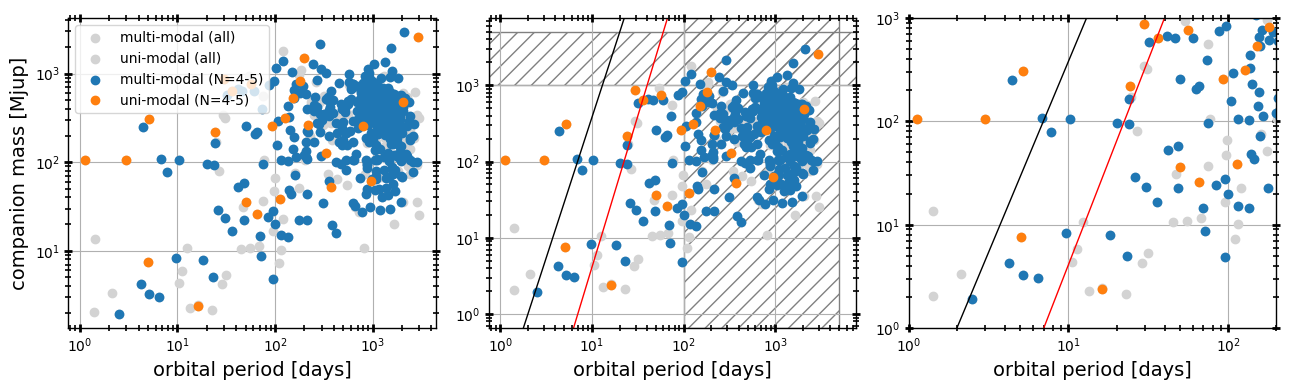

In [342]:


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4),dpi=100)


for ax in [ax1, ax2, ax3]:
    ax.scatter(mul_modal_df['P50'], mul_modal_df['Mj50'], label='multi-modal (all)', c='lightgrey')
    ax.scatter(uni_modal_df['P'], uni_modal_df['Msini_jup'], label='uni-modal (all)', c='lightgrey')

    ax.scatter(mul_good['P50'], mul_good['Mj50'], label='multi-modal (N=4-5)')
    ax.scatter(uni_good['P'], uni_good['Msini_jup'], label='uni-modal (N=4-5)')

    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('orbital period [days]')
    
    ax.grid()

ax2.axline((7, 1), (40, 1000), linewidth=1, color='r')
ax2.axline((2, 1), (13, 1000), linewidth=1, color='k')

ax3.axline((7, 1), (40, 1000), linewidth=1, color='r')
ax3.axline((2, 1), (13, 1000), linewidth=1, color='k')

ax1.legend(loc='upper left',fontsize=10)   
ax1.set_ylabel('companion mass [Mjup]')
    
ax2.axvspan(100,5000,edgecolor='grey',hatch='//',facecolor='None',zorder=-100)
ax2.axhspan(1000,5000,edgecolor='grey',hatch='//',facecolor='None',zorder=-100)


ax3.set_xlim(1,200)
ax3.set_ylim(1,1000)

plt.tight_layout()


mask1 = (np.array(mul_good['P50'])<180) & (np.array(mul_good['Mj50'])<1000)
mask2 = (np.array(uni_good['P'])<180) & (np.array(uni_good['Msini_jup'])<1000)

cut_1 = np.array(mul_good['APOGEE_ID'])[mask1]
cut_2 = np.array(uni_good['APOGEE_ID'])[mask2]
print('total within P<100 days & Mj<1000:',len(cut_1)+len(cut_2))
print('colored points left of red line:',18)
18/71

In [343]:
M_jup = 1.898e27               # Jupiter mass (kg)
day = 86400                    # seconds in a day


prob_e0  = np.load('simulation_data/probability_e=0.npy')
M_grid   = np.load('simulation_data/M_grid.npy') #kg
M_grid  /= M_jup #in Mjup
P_grid   = np.load('simulation_data/P_grid.npy') #seconds
# P_grid  /= day #in days

In [344]:
np.shape(prob_e0),np.shape(P_grid),np.shape(M_grid)

((500, 500), (500,), (500,))

In [345]:
# P_grid
# M_grid

In [346]:

def get_nearest_z(x1, y1, x_vals, y_vals, z_grid):
    # Find nearest indices in x and y
    ix = (np.abs(x_vals - x1)).argmin()
    iy = (np.abs(y_vals - y1)).argmin()
    
    # Return z at the nearest grid point
    return z_grid[iy, ix], x_vals[ix], y_vals[iy]

# Example usage:
P1, M1 = 523.4, 37.8
P1, M1 = 3, 7
x1, y1 = P1, M1

P_range = np.logspace(0, np.log10(365*10.), 100)
M_range = np.logspace(0, 3, 50)*M_jup         # companion mass (M*sin i)

x_vals = P_range*1
y_vals = M_range*1
z_grid = prob_e0*1

np.shape(x_vals),np.shape(y_vals),np.shape(z_grid)
z_value, nearest_x, nearest_y = get_nearest_z(x1, y1, x_vals, y_vals, z_grid)
print(z_value, nearest_x, nearest_y)

0.6766666666666667 2.9361337197847885 1.898e+27


0.6766666666666667


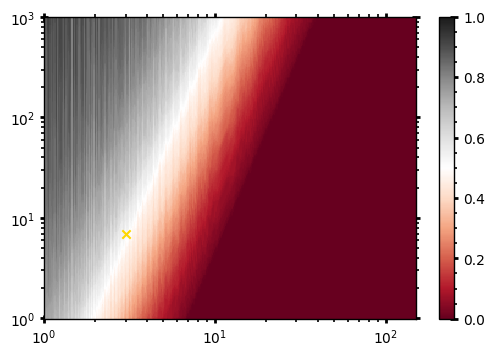

In [347]:
cmap_color = 'RdGy'
bounds = [0., 0.2, 0.4, 0.6, 0.8, 1.0]
cmap = plt.get_cmap(cmap_color, len(bounds))

plt.figure(dpi=100)
ax=plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

mesh=ax.pcolormesh(P_grid, M_grid, prob_e0,vmax=1,cmap=cmap_color)#, cmap=cmap, norm=norm)

plt.colorbar(mesh)
ax.scatter(P1, M1,c='gold',marker='x')
ax.grid(True,color='white')
ax.set_xlim(1,150)
print(z_value)
plt.show()

In [348]:
mul_modal_df['P50'], mul_modal_df['Mj50']

prob_mul = []

for index, row in mul_good.iterrows():
    P1, M1 = row['P50'],row['Mj50']
    p, _, _ = get_nearest_z(P1, M1, x_vals, y_vals, z_grid)
    prob_mul.append(p)

prob_uni = []

for index, row in uni_good.iterrows():
    P1, M1 = row['P'],row['Msini_jup']
    p, _, _ = get_nearest_z(P1, M1, x_vals, y_vals, z_grid)
    prob_uni.append(p)

print(np.sum(prob_mul),len(mul_good))
print(np.sum(prob_uni),len(uni_good))
print(np.sum(prob_mul)+np.sum(prob_uni),len(mul_good)+len(uni_good))


97.829 435
9.765 24
107.594 459


In [ ]:
import random
# random.random(0,1,10)
random.seed(42)
aa = np.array([round(random.uniform(0, 1),2) for i in range(3631)])
np.sum(aa),np.sum(aa)/3631
# aa

In [172]:
uni_P = np.array(uni_modal_dict['P'])
mul_P = np.array(mul_modal_dict['P50'])

len(uni_P[uni_P<10]),len(uni_P), len(mul_P)

(6, 62, 528)

In [70]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    @return:
        Msini: Msini in kg
    '''
    from scipy import optimize
    # define constants
    pi = np.pi
    G  = const.G
    
    # convert units to SI units
    K = abs((K*(u.km/u.second)).to(u.meter/u.second))
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # if Mp << Mstar:
    # Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a     = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    initial_guess = 0.1*u.Msun.to(u.kg)
    
    sol   = optimize.root(func, initial_guess, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success




In [156]:
print(len(n_samples[0]), len(n_samples[1]),len(yes_names),'total stars run:',len(n_samples[0])+len(n_samples[1]))

(len(n_samples[0]) + len(yes_names)) / (len(n_samples[0]) + len(n_samples[1])+ len(yes_names))


62 3097 528 total stars run: 3159


0.16002169785733658

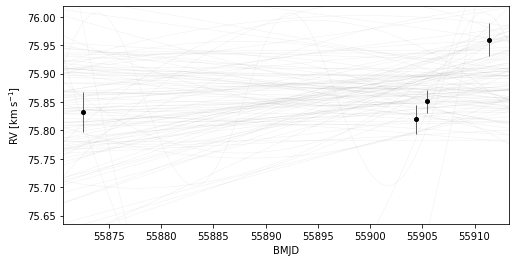

In [21]:
def reload(name,n=100):

    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    data    = np.load('apogee_reference_samples/%s.npy'%name)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    t = Time(data[0], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data[1]*u.km/u.s, rv_err=data[2]*u.km/u.s)
    
    _ = tj.plot_rv_curves(
            samples[:n],
            data=data,
            ax=ax,
        )
    plt.savefig('apogee_reference_samples/%s.png'%name,bbox_inches='tight',dpi=100)

#reload('2M07370225+2201156')

In [ ]:
len(np.array(n_samples)[np.array(n_samples)>1]),len(n_samples)
3093/3155

In [ ]:
ss

In [ ]:
def checking():
    
    files = glob.glob('apogee_reference_samples/*.hdf5')
    
    x = []
    
    for file in files:
        name = file.split('/')[-1].split('.')[0]
        if name in unique_apogee_id:
            samples = tj.JokerSamples.read(file)
            x.append(len(samples))
    x=np.array(x)
    print(len(x))
    print(len(x[x>256]))
#     plt.hist(x,bins='auto')
checking()

In [ ]:
tj.JokerSamples.read('apogee_reference_samples/2M07370225+2201156.hdf5')#['P']

In [ ]:
ss

In [ ]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    
    new_df = {'APOGEE_ID':[],
              'semi_amp': [],
              'logg': [],
              'deltat': []
             }
    
    
    for i,star in enumerate(unique_apogee_id):
        print(i, star)

        dtemp = merged[merged['APOGEE_ID'] == star]
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time = dtemp['JD']
        time = Time(time, format="jd", scale="tcb")
        mask = (err<10.)
        
        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time   = time.mjd
        if len(rv_vals) < 1: continue
        
        semi_k = (max(rv_vals) - min(rv_vals))*0.5
        log_g  = dtemp['LOGG'][0]
#         print(log_g, semi_k)
        new_df['APOGEE_ID'].append(star)
        new_df['semi_amp'].append(semi_k)
        new_df['logg'].append(log_g)
        new_df['deltat'].append(max(time)-min(time))
    return new_df  
        
#         data = [time, rv_vals, err]
#         data = np.array(data)
#         np.max()
#         np.save('apogee_reference_samples/%s.npy'%star, data )
        
#         joker_samples = run_joker(data, Pi=1, Pf=3000)
#         save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
#         joker_samples[0].write(save_dir, overwrite=True)
        #print('\n')
      
new_df = pipeline()
        

In [ ]:
def func1(logg):
    a, b = -0.60, 3.31
    log_v = a*logg+b
    return 10.**log_v
    

def func3(logg):
    siga, sigb = -0.04, -0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func4(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+1.5*siga
    b = b+1.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
    

In [ ]:
merged.keys()

In [ ]:
new_df_2 = pd.DataFrame(new_df)
new_df_2['exp_amp'] = func2(new_df_2['logg'])/1000.# func2()/1000.

mask = (new_df_2['semi_amp'] >= new_df_2['exp_amp'])

# PLOTTING
plt.figure(dpi=100)
xvals = np.linspace(0.5,3.5,1000)
plt.scatter(new_df_2['logg'], new_df_2['semi_amp'],label='red giants with N>4 visits')
plt.scatter(new_df_2[mask]['logg'], new_df_2[mask]['semi_amp'],label='binary candidates')
plt.plot(xvals, func1(xvals)/1000., c='k')
plt.plot(xvals, func2(xvals)/1000., c='r',ls='dashed')
plt.plot(xvals, func3(xvals)/1000., c='grey',ls='dashed')
plt.xlabel('Logg [dex]')
plt.ylabel('Semi-amplitude [km/s]')
plt.yscale('log')
plt.legend()


print(len(new_df_2[mask]),len(new_df_2),len(new_df_2[mask])/len(new_df_2))



In [ ]:
bins='auto'#np.linspace(0,2500, 25)
plt.figure(dpi=100)
_ = plt.hist(new_df_2['deltat'],bins=bins,alpha=0.5,label='red giants with N>4 visits')
_ = plt.hist(new_df_2[mask]['deltat'],bins=bins,alpha=0.5,label='binary candidates')
plt.xlabel('observation baseline [days]')
plt.ylabel('counts')
plt.legend()


In [ ]:
ss

In [ ]:
# 2M16073621+2252268.hdf5

# def load(name):
#         samples = JokerSamples.from_hdf5(results_f[star['APOGEE_ID']], 
#                                      poly_trend=poly_trend)
        

In [ ]:
# merge = join(apogee_dr16_visit, apogee_rg, keys='APOGEE_ID')
# VHELIO
# PERSIST_LOW
# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']==apogee_rg['APOGEE_ID'][0]]

In [ ]:
print(max(apogee_dr16['NVISITS']))
plt.figure()
plt.hist(apogee_dr16['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.hist(apogee_rg['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.show()

plt.figure()
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'])
plt.scatter(apogee_rg['TEFF'],apogee_rg['LOGG'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('teff')
plt.ylabel('logg')
plt.show()

In [ ]:
apogee_dr16['TARGFLAGS']
apogee_dr16[apogee_dr16['APOGEE_TARGET1']>=0]#apogee_dr16[['APOGEE_TARGET1','APOGEE_TARGET2']]

In [ ]:
# apogee_dr16#.keys()
len(apogee_rg)

In [ ]:
set(apogee_rg['WASH_DDO51_GIANT_FLAG'])#.keys()
